In [2]:
import numpy as np
import bilby
from scipy.io import loadmat
from pygwb import pe
from pygwb.baseline import Baseline
import bilby.gw.detector as bilbydet

# Running the pe module

In [3]:
 #import data
#take e.g. O3
frequencies, Y_HL, sigma_HL = np.loadtxt('C_O3_HL.dat', unpack=True, usecols=(0,1,2))
Y_HV, sigma_HV = np.loadtxt('C_O3_HV.dat', unpack=True, usecols=(1,2))
Y_LV, sigma_LV = np.loadtxt('C_O3_LV.dat', unpack=True, usecols=(1,2))

In [4]:
 #go up to 256 Hz
idx=np.argmin(np.abs(frequencies-256))
frequencies = frequencies[:idx]
#cut all of the data for frequencies > 256 Hz
sigma_HL = sigma_HL[:idx]
Y_HL = Y_HL[:idx]
sigma_HV = sigma_HV[:idx]
Y_HV = Y_HV[:idx]
sigma_LV = sigma_LV[:idx]
Y_LV = Y_LV[:idx]

In [5]:
#remove infinities from sigma measurements(O3)
inf_array=np.isinf(sigma_HL)
not_inf_array = ~ inf_array
sigma_HL = sigma_HL[not_inf_array]
Y_HL=Y_HL[not_inf_array]
sigma_HV = sigma_HV[not_inf_array]
Y_HV=Y_HV[not_inf_array]
sigma_LV = sigma_LV[not_inf_array]
Y_LV=Y_LV[not_inf_array]
frequencies=frequencies[not_inf_array]

inf_array=np.isinf(sigma_HV)
not_inf_array = ~ inf_array
sigma_HL = sigma_HL[not_inf_array]
Y_HL=Y_HL[not_inf_array]
sigma_HV = sigma_HV[not_inf_array]
Y_HV=Y_HV[not_inf_array]
sigma_LV = sigma_LV[not_inf_array]
Y_LV=Y_LV[not_inf_array]
frequencies=frequencies[not_inf_array]

inf_array=np.isinf(sigma_LV)
not_inf_array = ~ inf_array
sigma_HL = sigma_HL[not_inf_array]
Y_HL=Y_HL[not_inf_array]
sigma_HV = sigma_HV[not_inf_array]
Y_HV=Y_HV[not_inf_array]
sigma_LV = sigma_LV[not_inf_array]
Y_LV=Y_LV[not_inf_array]
frequencies=frequencies[not_inf_array]

In [6]:
point_estimates = [Y_HL, Y_HV, Y_LV]
sigmas = [sigma_HL, sigma_HV, sigma_LV]
H1 = bilbydet.get_empty_interferometer('H1')
L1 = bilbydet.get_empty_interferometer('L1')
V1 = bilbydet.get_empty_interferometer('V1')

HL = Baseline('H1L1', H1, L1)
HV = Baseline('H1V1', H1, V1)
LV = Baseline('L1V1', L1, V1)

HL.frequencies = frequencies
HV.frequencies = frequencies
LV.frequencies = frequencies


HL.point_estimate = Y_HL
HL.sigma = sigma_HL
HV.point_estimate = Y_HV
HV.sigma = sigma_HV
LV.point_estimate = Y_LV
LV.sigma = sigma_LV

/home/arianna.renzini/PROJECTS/pygwb/pygwb/baseline.py:299: UserWarning: Neither baseline nor interferometer sampling_frequency is set.
  warnings.warn(
/home/arianna.renzini/PROJECTS/pygwb/pygwb/baseline.py:196: UserWarning: Neither baseline nor interferometer duration is set.
  warnings.warn("Neither baseline nor interferometer duration is set.")


14:15 bilby INFO    : Running for label 'hlv_pl', output will be saved to './'
14:15 bilby INFO    : Search parameters:
14:15 bilby INFO    :   omega_ref = LogUniform(minimum=1e-13, maximum=1e-05, name='$\\Omega_{\\rm ref}$', latex_label='$\\Omega_{\\rm ref}$', unit=None, boundary=None)
14:15 bilby INFO    :   alpha = Gaussian(mu=0, sigma=3.5, name='$\\alpha$', latex_label='$\\alpha$', unit=None, boundary=None)
14:15 bilby INFO    : Single likelihood evaluation took 3.035e-03 s


14:15 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 1000, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': 10, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f3ccbc04ee0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
14:15 bilby INFO    : Checkpoint every check_point_delta_t = 600s
14:15 bilby INFO    : Using dynesty version 1.0.1
14:15 bilby INFO    : Using the bilby-implemented rwalk sa

14:16 bilby INFO    : Sampling time: 0:00:25.531356
14:16 bilby INFO    : Summary of results:
nsamples: 4353
ln_noise_evidence: 177774.109
ln_evidence: 177773.628 +/-  0.017
ln_bayes_factor: -0.482 +/-  0.017



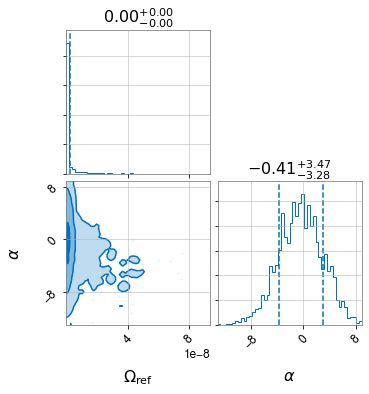

In [9]:
###############################################
###############Testing pl##################
###############################################

#choose pair likelihoods for the models you want to constrain with the data
#power law

kwargs_pl = {"baselines":[HL,HV,LV], "model_name":'PL', "fref":25}
model_pl = pe.PowerLawModel(**kwargs_pl)
priors_pl = {'omega_ref': bilby.core.prior.LogUniform(1e-13, 1e-5, '$\\Omega_{\\rm ref}$'),
                        'alpha': bilby.core.prior.Gaussian(0, 3.5, '$\\alpha$')}
hlv_pl=bilby.run_sampler(likelihood=model_pl,priors=priors_pl,sampler='dynesty', npoints=1000, walks=10, npool=10, outdir='./',label= 'hlv_pl', resume=False)
hlv_pl.plot_corner()  

14:18 bilby INFO    : Running for label 'hlv_bpl', output will be saved to './'
14:18 bilby INFO    : Search parameters:
14:18 bilby INFO    :   omega_ref = LogUniform(minimum=1e-13, maximum=1e-05, name='$\\Omega_{\\rm ref}$', latex_label='$\\Omega_{\\rm ref}$', unit=None, boundary=None)
14:18 bilby INFO    :   fbreak = Uniform(minimum=1, maximum=100, name='$f_{\\rm break}$', latex_label='$f_{\\rm break}$', unit=None, boundary=None)
14:18 bilby INFO    :   alpha_1 = Gaussian(mu=0, sigma=3.5, name='$\\alpha_1$', latex_label='$\\alpha_1$', unit=None, boundary=None)
14:18 bilby INFO    :   alpha_2 = Gaussian(mu=0, sigma=3.5, name='$\\alpha_2$', latex_label='$\\alpha_2$', unit=None, boundary=None)
14:18 bilby INFO    : Single likelihood evaluation took 3.312e-03 s


14:18 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 1000, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': 10, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f3ccbc0a7c0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
14:18 bilby INFO    : Checkpoint every check_point_delta_t = 600s
14:18 bilby INFO    : Using dynesty version 1.0.1
14:18 bilby INFO    : Using the bilby-implemented rwalk sa

14:18 bilby INFO    : Sampling time: 0:00:22.804098
14:18 bilby INFO    : Summary of results:
nsamples: 4164
ln_noise_evidence: 177774.109
ln_evidence: 177773.636 +/- 1501931.520
ln_bayes_factor: -0.474 +/- 1501931.520



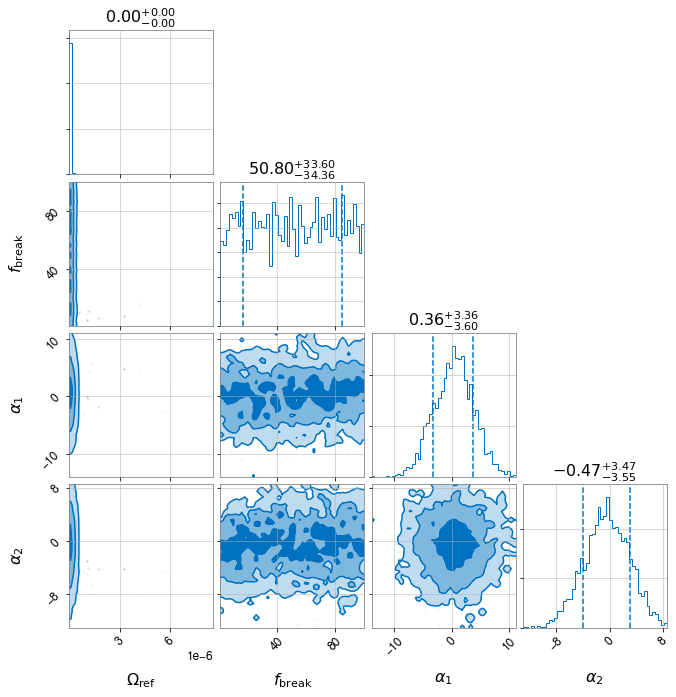

In [10]:
# ###############################################
# ###############Testing bpl##################
# ###############################################

kwargs_bpl = {"baselines": [HL, HV, LV], "model_name":'BPL'}
model_bpl = pe.BrokenPowerLawModel(**kwargs_bpl)
priors_bpl = {'omega_ref': bilby.core.prior.LogUniform(1e-13, 1e-5, '$\\Omega_{\\rm ref}$'),
            'fbreak': bilby.core.prior.Uniform(1, 100,'$f_{\\rm break}$'),
            'alpha_1': bilby.core.prior.Gaussian(0, 3.5, '$\\alpha_1$'),
            'alpha_2': bilby.core.prior.Gaussian(0, 3.5, '$\\alpha_2$')}
hlv_bpl=bilby.run_sampler(likelihood=model_bpl,priors=priors_bpl,sampler='dynesty', npoints=1000, walks=10,npool=10,outdir='./',label= 'hlv_bpl', resume=False)
hlv_bpl.plot_corner()

In [ ]:
###############################################
######### Testing triple_BPL##################
###############################################

# kwargs_triple_bpl = {"baselines":[HL,HV,LV],"model_name": 'TBPL'}
# model_triple_bpl = TripleBrokenPowerLawModel(**kwargs_triple_bpl)
# priors_triple_bpl = {'omega_ref': bilby.core.prior.LogUniform(1e-13, 1e-5, '$\\Omega_{\\rm ref}$'),
#                        'alpha_1': bilby.core.prior.Gaussian(0, 3.5, '$\\alpha_1$'),
#                       'alpha_2': bilby.core.prior.Gaussian(0, 3.5, '$\\alpha_2$'),
#                        'alpha_3': bilby.core.prior.Gaussian(0, 3.5, '$\\alpha_3$'),
#                      'fbreak1': bilby.core.prior.Uniform(1, 100,'$f_{\\rm break}^1$'), 
#                      'fbreak2': bilby.core.prior.Uniform(1, 100,'$f_{\\rm break}^2$')}
# hlv_triple_bpl = bilby.run_sampler(likelihood=model_triple_bpl,priors=priors_triple_bpl,sampler='dynesty', npoints=1000, walks=10,npool=10,outdir='./',label= 'hlv_tbpl', resume=False)
# hlv_triple_bpl.plot_corner()

In [ ]:
# ###############################################
# ######### Testing Smooth Broken PL#############
# ###############################################

# kwargs_sbpl = {"baselines":[HL,HV,LV],"model_name": 'SBPL'}
# model_sbpl = SmoothBrokenPowerLawModel(**kwargs_sbpl)
# priors_sbpl = {'omega_ref': bilby.core.prior.LogUniform(1e-13, 1e-5, '$\\Omega_{\\rm ref}$'),
#                   'fbreak': bilby.core.prior.Uniform(1, 256, '$f_{\\rm break}$'),
#                         'alpha_1': bilby.core.prior.Gaussian(0, 3.5, '$\\alpha_1$'),
#                        'alpha_2': bilby.core.prior.Gaussian(0, 3.5, '$\\alpha_2$'),
#                         'delta': bilby.core.prior.Uniform(0, 8, '$\\Delta$')}
# hlv_sbpl = bilby.run_sampler(likelihood=model_sbpl,priors=priors_sbpl,sampler='dynesty', npoints=1000, walks=10,npool=10,outdir='./',label= 'hlv_sbpl', resume=False)
# hlv_sbpl.plot_corner()

In [ ]:
# ###############################################
# ###############Testing tvs pl##################
# ###############################################

# kwargs_pl_sv={"baselines":[HL, HV, LV], "model_name":'PL_SV', "fref":25, "polarizations":['scalar', 'vector']}
# model_pl_sv = TVSPowerLawModel(**kwargs_pl_sv)
# priors_pl_sv = {'omega_ref_scalar': bilby.core.prior.LogUniform(1e-13, 1e-5, '$\\Omega_{\\rm ref,s}$'),
#                       'alpha_scalar': bilby.core.prior.Gaussian(0, 3.5, '$\\alpha_s$'),
#           'omega_ref_vector': bilby.core.prior.LogUniform(1e-13, 1e-5, '$\\Omega_{\\rm ref,v}$'),
#                       'alpha_vector': bilby.core.prior.Gaussian(0, 3.5, '$\\alpha_v$')}
# hlv_pl_sv=bilby.run_sampler(likelihood=model_pl_sv,priors=priors_pl_sv,sampler='dynesty', npoints=1000, walks=10,npool=10,outdir='./',label= 'hlv_pl_sv', resume=False)
# hlv_pl_sv.plot_corner()

In [ ]:
# ###############################################
# ######### Testing Parity Violation PL 1 #######
# ###############################################

# kwargs_pl_pv = {"baselines":[HL, HV, LV],"model_name": 'PL_PV', 'fref': 25}
# model_pl_pv = PVPowerLawModel(**kwargs_pl_pv)
# priors_pl_pv = {'omega_ref': bilby.core.prior.LogUniform(1e-13, 1e-5, '$\\Omega_{\\rm ref}$'),
#                        'alpha': bilby.core.prior.Gaussian(0, 3.5, '$\\alpha$'),
#                        'Pi': bilby.core.prior.Uniform(-1,1,'$\\Pi$')}
# hlv_pl_pv = bilby.run_sampler(likelihood=model_pl_pv,priors=priors_pl_pv,sampler='dynesty', npoints=1000, walks=10,npool=10,outdir='./',label= 'hlv_pl_pv', resume=False)
# hlv_pl_pv.plot_corner()

In [ ]:
##############################################
######## Testing Parity Violation PL 2 #######
##############################################

# kwargs_pv_pl_2 = {"baselines":[HL, HV, LV],"model_name": 'PL_PV_2', 'fref': 25}
# model_pv_pl_2 = PVPowerLawModel2(**kwargs_pv_pl_2)
# priors_pv_pl_2 = {'omega_ref': bilby.core.prior.LogUniform(1e-13, 1e-5, '$\\Omega_{\\rm ref}$'),
#                      'alpha': bilby.core.prior.Gaussian(0, 3.5, '$\\alpha$'),
#                        'beta': bilby.core.prior.Uniform(-2,0,'$\\beta$')}
# hlv_pv_pl_2 = bilby.run_sampler(likelihood=model_pv_pl_2,priors=priors_pv_pl_2,sampler='dynesty', npoints=1000, walks=10,npool=10,outdir='./',label= 'hlv_pv_pl_2', resume=False)
# hlv_pv_pl_2.plot_corner()

In [2]:
# ##############################################
# ######## Testing Schumann #######
# ##############################################

# frequencies, Y_HL, sigma_HL = np.loadtxt('C_O3_HL.dat', unpack=True, usecols=(0,1,2))
# Y_HV, sigma_HV = np.loadtxt('C_O3_HV.dat', unpack=True, usecols=(1,2))
# Y_LV, sigma_LV = np.loadtxt('C_O3_LV.dat', unpack=True, usecols=(1,2))
# #load magnetic data
# mag_data = loadmat('/home/patrick.meyers/git_repos/o3-isotropic-final/magnetic/magnetic_data_product_for_pe.mat')  
# M_HL=(mag_data['hl']['ptEst_mag'][0][0].real)[0]
# M_HV=(mag_data['hv']['ptEst_mag'][0][0].real)[0]
# M_LV=(mag_data['lv']['ptEst_mag'][0][0].real)[0]

# #go up to 99 Hz
# idx=np.argmin(np.abs(frequencies-99))
# frequencies = frequencies[:idx]
# #cut all of the data for frequencies > 99 Hz
# sigma_HL = sigma_HL[:idx]
# Y_HL = Y_HL[:idx]
# M_HL = M_HL[:idx]
# sigma_HV = sigma_HV[:idx]
# Y_HV = Y_HV[:idx]
# M_HV = M_HV[:idx]
# sigma_LV = sigma_LV[:idx]
# Y_LV = Y_LV[:idx]
# M_LV = M_LV[:idx]

# #remove infinities from sigma measurements(O3a)
# inf_array=np.isinf(sigma_HL)
# not_inf_array = ~ inf_array
# sigma_HL = sigma_HL[not_inf_array]
# Y_HL=Y_HL[not_inf_array]
# M_HL=M_HL[not_inf_array]
# sigma_HV = sigma_HV[not_inf_array]
# Y_HV=Y_HV[not_inf_array]
# M_HV=M_HV[not_inf_array]
# sigma_LV = sigma_LV[not_inf_array]
# Y_LV=Y_LV[not_inf_array]
# M_LV=M_LV[not_inf_array]
# frequencies=frequencies[not_inf_array]

# inf_array=np.isinf(sigma_HV)
# not_inf_array = ~ inf_array
# sigma_HL = sigma_HL[not_inf_array]
# Y_HL=Y_HL[not_inf_array]
# M_HL=M_HL[not_inf_array]
# sigma_HV = sigma_HV[not_inf_array]
# Y_HV=Y_HV[not_inf_array]
# M_HV=M_HV[not_inf_array]
# sigma_LV = sigma_LV[not_inf_array]
# Y_LV=Y_LV[not_inf_array]
# M_LV=M_LV[not_inf_array]
# frequencies=frequencies[not_inf_array]

# inf_array=np.isinf(sigma_LV)
# not_inf_array = ~ inf_array
# sigma_HL = sigma_HL[not_inf_array]
# Y_HL=Y_HL[not_inf_array]
# M_HL=M_HL[not_inf_array]
# sigma_HV = sigma_HV[not_inf_array]
# Y_HV=Y_HV[not_inf_array]
# M_HV=M_HV[not_inf_array]
# sigma_LV = sigma_LV[not_inf_array]
# Y_LV=Y_LV[not_inf_array]
# M_LV=M_LV[not_inf_array]
# frequencies=frequencies[not_inf_array]

# #remove nans from mag data
# nan_array = np.isnan(M_HL)
# not_nan_array = ~ nan_array
# sigma_HL = sigma_HL[not_nan_array]
# Y_HL=Y_HL[not_nan_array]
# M_HL=M_HL[not_nan_array]
# sigma_HV = sigma_HV[not_nan_array]
# Y_HV=Y_HV[not_nan_array]
# M_HV=M_HV[not_nan_array]
# sigma_LV = sigma_LV[not_nan_array]
# Y_LV=Y_LV[not_nan_array]
# M_LV=M_LV[not_nan_array]
# frequencies=frequencies[not_nan_array]

# nan_array = np.isnan(M_HV)
# not_nan_array = ~ nan_array
# sigma_HL = sigma_HL[not_nan_array]
# Y_HL=Y_HL[not_nan_array]
# M_HL=M_HL[not_nan_array]
# sigma_HV = sigma_HV[not_nan_array]
# Y_HV=Y_HV[not_nan_array]
# M_HV=M_HV[not_nan_array]
# sigma_LV = sigma_LV[not_nan_array]
# Y_LV=Y_LV[not_nan_array]
# M_LV=M_LV[not_nan_array]
# frequencies=frequencies[not_nan_array]

# nan_array = np.isnan(M_LV)
# not_nan_array = ~ nan_array
# sigma_HL = sigma_HL[not_nan_array]
# Y_HL=Y_HL[not_nan_array]
# M_HL=M_HL[not_nan_array]
# sigma_HV = sigma_HV[not_nan_array]
# Y_HV=Y_HV[not_nan_array]
# M_HV=M_HV[not_nan_array]
# sigma_LV = sigma_LV[not_nan_array]
# Y_LV=Y_LV[not_nan_array]
# M_LV=M_LV[not_nan_array]
# frequencies=frequencies[not_nan_array]

# point_estimates = [Y_HL, Y_HV, Y_LV]
# sigmas = [sigma_HL, sigma_HV, sigma_LV]
# H1 = bilbydet.get_empty_interferometer('H1')
# L1 = bilbydet.get_empty_interferometer('L1')
# V1 = bilbydet.get_empty_interferometer('V1')

# HL = Baseline('HL', H1, L1)
# HV = Baseline('HV', H1, V1)
# LV = Baseline('LV', L1, V1)

# HL.frequencies = frequencies
# HV.frequencies = frequencies
# LV.frequencies = frequencies

# HL.M_f = M_HL
# HV.M_f = M_HV
# LV.M_f = M_LV

# HL.point_estimate = Y_HL
# HL.sigma = sigma_HL
# HV.point_estimate = Y_HV
# HV.sigma = sigma_HV
# LV.point_estimate = Y_LV
# LV.sigma = sigma_LV

# kwargs_schu={"baselines":[HL, HV, LV], "model_name":'Schu', "polarizations":['tensor']}
# model_schu = SchumannModel(**kwargs_schu)
# print(model_schu.ifos)
# priors_schu = {'kappa_H': bilby.core.prior.LogUniform(0.01, 10, '$\\kappa_H$'),
#             'kappa_L': bilby.core.prior.LogUniform(0.01, 10, '$\\kappa_L$'),
#             'kappa_V': bilby.core.prior.LogUniform(0.01, 10, '$\\kappa_V$'),
#             'beta_H': bilby.core.prior.Uniform(0.0, 12.0, '$\\beta_H$'),
#             'beta_L': bilby.core.prior.Uniform(1.0, 10.0, '$\\beta_L$'),
#            'beta_V': bilby.core.prior.Uniform(0.0, 7.0, '$\\beta_V$')}
# hlv_schu=bilby.run_sampler(likelihood=model_schu,priors=priors_schu,sampler='dynesty', npoints=1000, walks=10,npool=10,outdir='./',label= 'hlv_schu', resume=False)
# hlv_schu.plot_corner()

In [3]:
# # ##############################################
# # ######## Testing Schumann + pl #######
# # ##############################################
# #########combining models
# #https://stackoverflow.com/questions/9667818/python-how-to-merge-two-class

# #import data
# #take e.g. O3
# frequencies, Y_HL, sigma_HL = np.loadtxt('C_O3_HL.dat', unpack=True, usecols=(0,1,2))
# Y_HV, sigma_HV = np.loadtxt('C_O3_HV.dat', unpack=True, usecols=(1,2))
# Y_LV, sigma_LV = np.loadtxt('C_O3_LV.dat', unpack=True, usecols=(1,2))
# #load magnetic data
# mag_data = loadmat('/home/patrick.meyers/git_repos/o3-isotropic-final/magnetic/magnetic_data_product_for_pe.mat')  
# M_HL=(mag_data['hl']['ptEst_mag'][0][0].real)[0]
# M_HV=(mag_data['hv']['ptEst_mag'][0][0].real)[0]
# M_LV=(mag_data['lv']['ptEst_mag'][0][0].real)[0]

# #go up to 99 Hz
# idx=np.argmin(np.abs(frequencies-99))
# frequencies = frequencies[:idx]
# #cut all of the data for frequencies > 99 Hz
# sigma_HL = sigma_HL[:idx]
# Y_HL = Y_HL[:idx]
# M_HL = M_HL[:idx]
# sigma_HV = sigma_HV[:idx]
# Y_HV = Y_HV[:idx]
# M_HV = M_HV[:idx]
# sigma_LV = sigma_LV[:idx]
# Y_LV = Y_LV[:idx]
# M_LV = M_LV[:idx]

# #remove infinities from sigma measurements(O3a)
# inf_array=np.isinf(sigma_HL)
# not_inf_array = ~ inf_array
# sigma_HL = sigma_HL[not_inf_array]
# Y_HL=Y_HL[not_inf_array]
# M_HL=M_HL[not_inf_array]
# sigma_HV = sigma_HV[not_inf_array]
# Y_HV=Y_HV[not_inf_array]
# M_HV=M_HV[not_inf_array]
# sigma_LV = sigma_LV[not_inf_array]
# Y_LV=Y_LV[not_inf_array]
# M_LV=M_LV[not_inf_array]
# frequencies=frequencies[not_inf_array]

# inf_array=np.isinf(sigma_HV)
# not_inf_array = ~ inf_array
# sigma_HL = sigma_HL[not_inf_array]
# Y_HL=Y_HL[not_inf_array]
# M_HL=M_HL[not_inf_array]
# sigma_HV = sigma_HV[not_inf_array]
# Y_HV=Y_HV[not_inf_array]
# M_HV=M_HV[not_inf_array]
# sigma_LV = sigma_LV[not_inf_array]
# Y_LV=Y_LV[not_inf_array]
# M_LV=M_LV[not_inf_array]
# frequencies=frequencies[not_inf_array]

# inf_array=np.isinf(sigma_LV)
# not_inf_array = ~ inf_array
# sigma_HL = sigma_HL[not_inf_array]
# Y_HL=Y_HL[not_inf_array]
# M_HL=M_HL[not_inf_array]
# sigma_HV = sigma_HV[not_inf_array]
# Y_HV=Y_HV[not_inf_array]
# M_HV=M_HV[not_inf_array]
# sigma_LV = sigma_LV[not_inf_array]
# Y_LV=Y_LV[not_inf_array]
# M_LV=M_LV[not_inf_array]
# frequencies=frequencies[not_inf_array]

# #remove nans from mag data
# nan_array = np.isnan(M_HL)
# not_nan_array = ~ nan_array
# sigma_HL = sigma_HL[not_nan_array]
# Y_HL=Y_HL[not_nan_array]
# M_HL=M_HL[not_nan_array]
# sigma_HV = sigma_HV[not_nan_array]
# Y_HV=Y_HV[not_nan_array]
# M_HV=M_HV[not_nan_array]
# sigma_LV = sigma_LV[not_nan_array]
# Y_LV=Y_LV[not_nan_array]
# M_LV=M_LV[not_nan_array]
# frequencies=frequencies[not_nan_array]

# nan_array = np.isnan(M_HV)
# not_nan_array = ~ nan_array
# sigma_HL = sigma_HL[not_nan_array]
# Y_HL=Y_HL[not_nan_array]
# M_HL=M_HL[not_nan_array]
# sigma_HV = sigma_HV[not_nan_array]
# Y_HV=Y_HV[not_nan_array]
# M_HV=M_HV[not_nan_array]
# sigma_LV = sigma_LV[not_nan_array]
# Y_LV=Y_LV[not_nan_array]
# M_LV=M_LV[not_nan_array]
# frequencies=frequencies[not_nan_array]

# nan_array = np.isnan(M_LV)
# not_nan_array = ~ nan_array
# sigma_HL = sigma_HL[not_nan_array]
# Y_HL=Y_HL[not_nan_array]
# M_HL=M_HL[not_nan_array]
# sigma_HV = sigma_HV[not_nan_array]
# Y_HV=Y_HV[not_nan_array]
# M_HV=M_HV[not_nan_array]
# sigma_LV = sigma_LV[not_nan_array]
# Y_LV=Y_LV[not_nan_array]
# M_LV=M_LV[not_nan_array]
# frequencies=frequencies[not_nan_array]

# point_estimates = [Y_HL, Y_HV, Y_LV]
# sigmas = [sigma_HL, sigma_HV, sigma_LV]
# H1 = bilbydet.get_empty_interferometer('H1')
# L1 = bilbydet.get_empty_interferometer('L1')
# V1 = bilbydet.get_empty_interferometer('V1')

# HL = Baseline('HL', H1, L1)
# HV = Baseline('HV', H1, V1)
# LV = Baseline('LV', L1, V1)

# HL.frequencies = frequencies
# HV.frequencies = frequencies
# LV.frequencies = frequencies

# HL.M_f = M_HL
# HV.M_f = M_HV
# LV.M_f = M_LV

# HL.point_estimate = Y_HL
# HL.sigma = sigma_HL
# HV.point_estimate = Y_HV
# HV.sigma = sigma_HV
# LV.point_estimate = Y_LV
# LV.sigma = sigma_LV

# gw_schu = type('gw_schu', (PowerLawModel,SchumannModel), dict(c='c'))
# #instc = pl_schu('kwargs')
# kwargs={"baselines":[HL, HV, LV], "model_name":'PL+Schu', "polarizations":['tensor'],"fref":25}
# model = gw_schu(**kwargs)

# priors= {'kappa_H': bilby.core.prior.LogUniform(0.01, 10, '$\\kappa_H$'),
#             'kappa_L': bilby.core.prior.LogUniform(0.01, 10, '$\\kappa_L$'),
#             'kappa_V': bilby.core.prior.LogUniform(0.01, 10, '$\\kappa_V$'),
#             'beta_H': bilby.core.prior.Uniform(0.0, 12.0, '$\\beta_H$'),
#             'beta_L': bilby.core.prior.Uniform(1.0, 10.0, '$\\beta_L$'),
#            'beta_V': bilby.core.prior.Uniform(0.0, 7.0, '$\\beta_V$'),
#             'omega_ref': bilby.core.prior.LogUniform(1e-13, 1e-5, '$\\Omega_{\\rm ref}$'),
#              'alpha': bilby.core.prior.Gaussian(0, 3.5, '$\\alpha$')}
# hlv_gw_schu=bilby.run_sampler(likelihood=model,priors=priors,sampler='dynesty', npoints=1000, walks=10,npool=10,outdir='./',label= 'hlv_gw_schu', resume=False)
# hlv_gw_schu.plot_corner()